### Importing Libraries.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim, nn 
from PIL import Image
import torch.nn.functional as F  
from torchsummary import summary

### Data Preprocessing and Visualization.

In [2]:
train_dataset = datasets.MNIST(root='./data',download=True, train=True, transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.CenterCrop(28),
    transforms.Normalize((0.5,), (0.5,))
]))
val_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))

In [3]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)

In [4]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

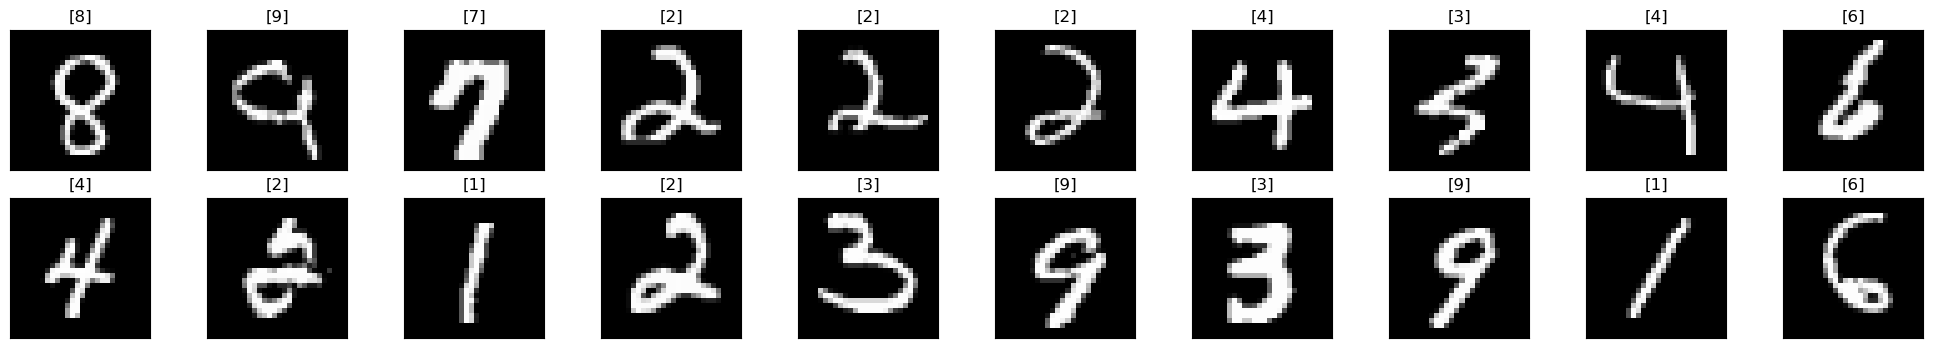

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

### Making the Model.

In [6]:
class Net(nn.Module):
    def __init__(self, nc =1, nf = 10):
      super().__init__()
      self.conv1 = nn.Conv2d(nc, nf, 5, 1)
      self.conv2 = nn.Conv2d(nf, nf*2, 5, 1)
      self.fc1 = nn.Linear(4*4*nf*2, 50)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(50, 10)
    def forward(self, x, nf=10):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*nf*2)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x
     


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
model = Net().to(device)
summary(model, (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
            Linear-3                   [-1, 50]          16,050
           Dropout-4                   [-1, 50]               0
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [9]:
# from torchsummary import summary
# summary(model, (1, 32))

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [11]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(train_loader)
    epoch_acc = running_corrects.float()/ len(train_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(val_loader)
    val_epoch_acc = val_running_corrects.float()/ len(val_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9645, acc 70.1233 
validation loss: 0.4665, validation acc 85.7600 
epoch : 2
training loss: 0.3976, acc 88.0617 
validation loss: 0.3128, validation acc 90.5100 
epoch : 3
training loss: 0.2891, acc 91.4550 
validation loss: 0.2405, validation acc 92.7200 
epoch : 4
training loss: 0.2387, acc 93.0067 
validation loss: 0.2035, validation acc 93.8700 
epoch : 5
training loss: 0.2072, acc 93.9600 
validation loss: 0.1829, validation acc 94.4400 
epoch : 6
training loss: 0.1846, acc 94.6400 
validation loss: 0.1659, validation acc 95.1700 
epoch : 7
training loss: 0.1683, acc 95.0133 
validation loss: 0.1578, validation acc 95.1600 
epoch : 8
training loss: 0.1608, acc 95.3233 
validation loss: 0.1379, validation acc 95.8800 
epoch : 9
training loss: 0.1474, acc 95.7200 
validation loss: 0.1342, validation acc 95.9900 
epoch : 10
training loss: 0.1416, acc 95.8667 
validation loss: 0.1301, validation acc 96.0600 
epoch : 11
training loss: 0.1337, acc 96.1000 
va

### Plotting the Loss and Accuracy per iteration.

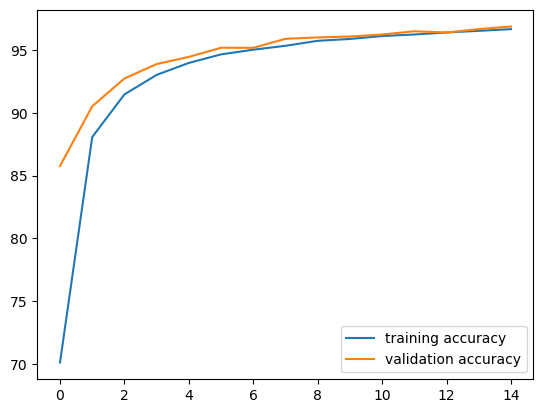

In [12]:
plt.plot([outputs.cpu().detach().numpy() for outputs in running_corrects_history], label='training accuracy')
plt.plot([outputs.cpu().detach().numpy() for outputs in val_running_corrects_history], label='validation accuracy')
plt.legend()

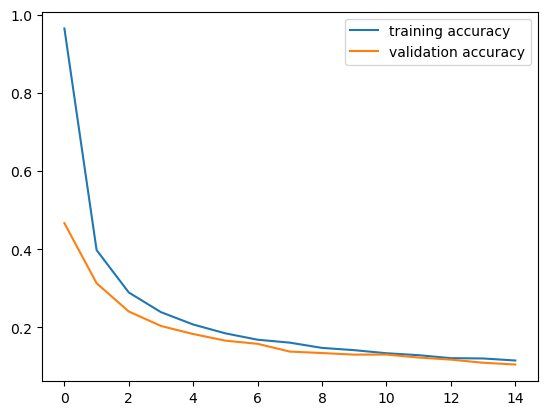

In [17]:
plt.plot(running_loss_history, label='training accuracy')
plt.plot(val_running_loss_history, label='validation accuracy')
plt.legend()

In [47]:
def predict(idx):
    image = im_convert(images[idx])
    output = model(images[idx].to(device))
    _, output_label = torch.max(output, 1)
    
    plt.imshow(image, cmap='gray', label=output_label)
    plt.legend()
    print("Predicted Label: {}".format(output_label.cpu().numpy()))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Predicted Label: [4]


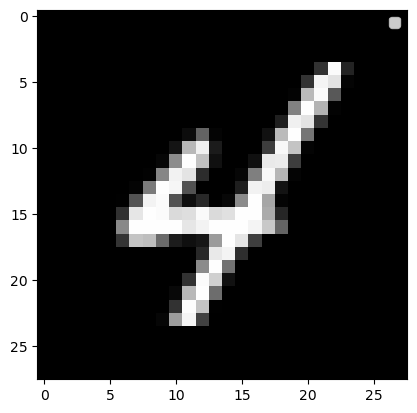

In [48]:
predict(46)

In [ ]:
torch.save(model.state_dict(), 'model.pth')